## Feedforward NN on Test Dataset

Getting the basic NN implementation working for a subset of the dataset. Ouput should be an action_taken label from the options below:

| Code | Description                                      |
|:----:|:-------------------------------------------------|
| 1    | Loan originated                                  |
| 2    | Application approved but not accepted            |
| 3    | Application denied                               |
| 4    | Application withdrawn by applicant               |
| 5    | File closed for incompleteness                   |
| 6    | Purchased loan                                   |
| 7    | Preapproval request denied                       |
| 8    | Preapproval request approved but not accepted    |

In [1]:
import numpy as np
from models.feedforward import FeedForwardModel, MortageDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import random
import os

In [2]:
# Load data with low_memory=False to handle mixed types properly
df = pd.read_csv("../datasets/500ktest_dataset_lar.csv", low_memory=False)
print(f"Data shape: {df.shape}")
print(f"\nData types:\n{df.dtypes.value_counts()}")
df.info()

Data shape: (499889, 74)

Data types:
int64      41
object     24
float64     9
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499889 entries, 0 to 499888
Data columns (total 74 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Unnamed: 0                                499889 non-null  int64  
 1   activity_year                             499889 non-null  int64  
 2   lei                                       499889 non-null  object 
 3   derived_msa_md                            499889 non-null  int64  
 4   state_code                                491047 non-null  object 
 5   county_code                               487609 non-null  float64
 6   census_tract                              485422 non-null  float64
 7   conforming_loan_limit                     498060 non-null  object 
 8   derived_loan_product_type                 499889 non-null 

## Preprocess


In [3]:
target='action_taken'
print("Number of NaNs:", df[target].isna().sum())
print(f"Target distribution:\n{df[target].value_counts().sort_index()}")
print("First, we are going to drop all the columns where action_taken={4, 5, 6, 7, 8}. ")
df = df[~df["action_taken"].isin([4,5,6,7,8])].copy()
print(f"This leaves us with {len(df)} rows")
#Next we combine categories 1 and 2 because they both indicate the loan was approved.
print("Combining categories 1 and 2 because they both indicate loan approval")
df['action_taken']=df['action_taken'].isin([1,2]).astype(int)
print(f"Binary target distribution:\n{df[target].value_counts().sort_index()}")

Number of NaNs: 0
Target distribution:
action_taken
1    252377
2     14605
3     85576
4     62995
5     23941
6     52115
7      1963
8      6317
Name: count, dtype: int64
First, we are going to drop all the columns where action_taken={4, 5, 6, 7, 8}. 
This leaves us with 352558 rows
Combining categories 1 and 2 because they both indicate loan approval
Binary target distribution:
action_taken
0     85576
1    266982
Name: count, dtype: int64


### Unused/Optional Features
1. Census features are optional because they are appended to the public HMDA data after collection, and thus are not used in initial loan approval
2. Irrelevant features are dropped because they consist of categories such as AUS1 (the automated underwriting system(s) (AUS) used by the financial institution to evaluate the application) which ideally should have no impact on an application because they are not borrower statistics. Other lender choice features also include credit score type, which the borrower does not know. 
3. Data Leakage features contain information that is only available after loan approval. For example, the 'intro_rate_period' which only exists when the loan reaches the underwriting stage, or 'denial_reason_1' which only exists when applications are denied. However, these might be good for explainability reasons in post-training.
4. Demographic features are protected features such as sex, race and age. These features are removed from the model to ensure compliance with regulations ('Equal Credit Opportunity Act') which prevent them from being used in a credit decision. However, we acknowledging that this demographic-blind approach may still leave residual bias, which is beyond the scope of this project in interpretability.

In [4]:
#to_process
census_features=['tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units']
irrelevant_feat = ['aus_1','submission_of_application', 'Unnamed: 0', 'activity_year', 'applicant_credit_score_type', 'co_applicant_credit_score_type']
leakage_feat=["denial_reason_1", "interest_rate",       
    "total_loan_costs",   
    "origination_charges", 
    "discount_points",     
    "lender_credits",       
    'rate_spread', 'hoepa_status', 'purchaser_type']
protected_feat=['derived_ethnicity', 'derived_race', 'derived_sex', 'applicant_ethnicity_1',
       'co_applicant_ethnicity_1', 'applicant_ethnicity_observed',
       'co_applicant_ethnicity_observed', 'applicant_race_1',
       'co_applicant_race_1', 'applicant_race_observed',
       'co_applicant_race_observed', 'applicant_sex', 'co_applicant_sex',
       'applicant_sex_observed', 'co_applicant_sex_observed', 'applicant_age',
       'co_applicant_age', 'applicant_age_above_62',
       'co_applicant_age_above_62']


feature='denial_reason_1' #Example of data leakage
missing=df.groupby(target)[feature].apply(lambda x: (x==10).sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
#print("Number of NaNs:", df[feature].isna().sum())
#print(df[feature].value_counts().head(5))
print("We can see that denial reason almost always takes the value of 10 when the action_taken=1: loan is approved. This is data leakage.\n")

feature='rate_spread' #Example of data leakage
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
#print("Number of NaNs:", df[feature].isna().sum())
#print(df[feature].value_counts().head(5))
print("We can see that the rate_spread is always exempt when the action_taken=0: loan is denied.\n")

feature='lender_credits'
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")


feature='purchaser_type'
missing=df.groupby(target)[feature].apply(lambda x: (x==0).sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")


feature='interest_rate'
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")

Percentage of missing values of denial_reason_1 per action_taken:
 action_taken
0    0.000000
1    0.972174
Name: denial_reason_1, dtype: float64
We can see that denial reason almost always takes the value of 10 when the action_taken=1: loan is approved. This is data leakage.

Percentage of missing values of rate_spread per action_taken:
 action_taken
0    0.985019
1    0.093939
Name: rate_spread, dtype: float64
We can see that the rate_spread is always exempt when the action_taken=0: loan is denied.

Percentage of missing values of lender_credits per action_taken:
 action_taken
0    0.984844
1    0.752414
Name: lender_credits, dtype: float64
Number of NaNs: 285160
lender_credits
Exempt    10204
1000.0      768
500.0       657
50.0        459
500.00      379
Name: count, dtype: int64 

Percentage of missing values of purchaser_type per action_taken:
 action_taken
0    1.000000
1    0.436119
Name: purchaser_type, dtype: float64
Number of NaNs: 0
purchaser_type
0     202012
71     33763


In [5]:
#Dropping the above features
todrop=census_features+irrelevant_feat+leakage_feat+protected_feat
df_cleaned=df.drop(columns=todrop)
df_cleaned.head(20)
print(f"There are now {len(df_cleaned.columns)} features for prediction in this cleaned dataset.")
print(df_cleaned.columns)
print(f"Each feature in this list is manually examined and sorted into categories outlined in the next section before encoding. We also discovered existence of mixed data types in various columns that are dealt with via feature engineering.")



There are now 33 features for prediction in this cleaned dataset.
Index(['lei', 'derived_msa_md', 'state_code', 'county_code', 'census_tract',
       'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'action_taken', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open_end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'combined_loan_to_value_ratio', 'loan_term',
       'intro_rate_period', 'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features', 'property_value',
       'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'debt_to_income_ratio', 'initially_payable_to_institution'],
      dtype='object')
Each feature in this list is manually examined and sorted into categories outlined in the next section be

## Case1.1: Low Dimensional Categoricals

In [6]:
low_dim_cat=['occupancy_type', 'manufactured_home_land_property_interest', 'manufactured_home_secured_property_type', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'loan_type', 'loan_purpose', 'lien_status', 'initially_payable_to_institution']

#ToDrop:
todrop_redundant=[]
counts = df_cleaned.groupby(['loan_type', 'lien_status'])['derived_loan_product_type'].nunique()
print("The derived loan product type is described as a join of loan type and lien status. This graph verifies that it is fully determined by the other 2 variables, so we can drop the the derived_loan_product_type variable.")
print(counts)
todrop_redundant.append('derived_loan_product_type')

counts = df_cleaned.groupby(['construction_method', 'total_units'])['derived_dwelling_category'].nunique()
print("\nThe derived_dwelling_category is also a join from the Construction Method and Total Units fields.")
print(counts)
todrop_redundant.append('derived_dwelling_category')

df_cleaned=df_cleaned.drop(columns=todrop_redundant)
low_dim_cat=[j for j in low_dim_cat if j not in todrop_redundant]

The derived loan product type is described as a join of loan type and lien status. This graph verifies that it is fully determined by the other 2 variables, so we can drop the the derived_loan_product_type variable.
loan_type  lien_status
1          1              1
           2              1
2          1              1
           2              1
3          1              1
4          1              1
           2              1
Name: derived_loan_product_type, dtype: int64

The derived_dwelling_category is also a join from the Construction Method and Total Units fields.
construction_method  total_units
1                    1              1
                     100-149        1
                     2              1
                     25-49          1
                     3              1
                     4              1
                     5-24           1
                     50-99          1
                     >149           1
2                    1              1
       

In [7]:
print(df_cleaned[low_dim_cat].isna().sum(), '\n')
for j in low_dim_cat:
    print("Column data type:", df_cleaned[j].dtype)
    print(df_cleaned[j].value_counts())

occupancy_type                                 0
manufactured_home_land_property_interest       0
manufactured_home_secured_property_type        0
conforming_loan_limit                       1568
loan_type                                      0
loan_purpose                                   0
lien_status                                    0
initially_payable_to_institution               0
dtype: int64 

Column data type: int64
occupancy_type
1    317086
3     28448
2      7024
Name: count, dtype: int64
Column data type: int64
manufactured_home_land_property_interest
5       322694
1        12019
1111     10318
3         5417
4         1978
2          132
Name: count, dtype: int64
Column data type: int64
manufactured_home_secured_property_type
3       322638
2        10909
1111     10195
1         8816
Name: count, dtype: int64
Column data type: object
conforming_loan_limit
C     340967
NC      9975
U         48
Name: count, dtype: int64
Column data type: int64
loan_type
1    280407
2  

A cursory examination of the data ranges shows us that all columns are already in consistent data types. Since tabnet takes either integers or strings for categoricals. Cross-checking against data schema, we will leave the Exempt entries, encoded as 1111 in hopes tabnet can pick up these values. We will also convert the np.nan and U entries into 1111 as well.

In [8]:

replace_map = {
    'conforming_loan_limit': {np.nan: 1111,
                              'C': 1,
                              'NC': 0,
                              'U': 1111}
}
df_cleaned=df_cleaned.replace(replace_map, inplace=False)
for j in low_dim_cat:
    df_cleaned[j]=df_cleaned[j].astype(int)
    print("Column data type:", df_cleaned[j].dtype)
    print(df_cleaned[j].value_counts())
        

Column data type: int64
occupancy_type
1    317086
3     28448
2      7024
Name: count, dtype: int64
Column data type: int64
manufactured_home_land_property_interest
5       322694
1        12019
1111     10318
3         5417
4         1978
2          132
Name: count, dtype: int64
Column data type: int64
manufactured_home_secured_property_type
3       322638
2        10909
1111     10195
1         8816
Name: count, dtype: int64
Column data type: int64
conforming_loan_limit
1       340967
0         9975
1111      1616
Name: count, dtype: int64
Column data type: int64
loan_type
1    280407
2     45136
3     25191
4      1824
Name: count, dtype: int64
Column data type: int64
loan_purpose
1     175184
32     49382
4      46260
2      41701
31     39888
5        143
Name: count, dtype: int64
Column data type: int64
lien_status
1    255164
2     97394
Name: count, dtype: int64
Column data type: int64
initially_payable_to_institution
1       318303
2        17024
1111     10156
3         7075

/var/folders/lv/hk3y0lgs0nngk_1q5qq128rc0000gn/T/ipykernel_77279/3088743024.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned=df_cleaned.replace(replace_map, inplace=False)


## Case 1.2: Categoricals Features with High Dimension
This is basic categorical data that requires usage of embeddings due to high dimensionality. The embedding is naturally dealt with by tabnet by passing as integers.

In [9]:
high_dim_cat=['lei', 'derived_msa_md', 'census_tract', 'county_code', 'state_code']
feature=high_dim_cat[1]
for feature in high_dim_cat:
    print(df_cleaned[feature].value_counts().head(5))
    print("Column data type:", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(f"Number of dimensions: {len(df_cleaned[feature].value_counts())}")

lei
549300FGXN1K3HLB1R50    18425
549300HW662MN1WU8550    17629
B4TYDEB6GKMZO031MB27     6820
X05BVSK68TQ7YTOSNR22     6008
6BYL5QZYBDK8S7L73M02     5405
Name: count, dtype: int64
Column data type: object
Number of NaNs: 0
Number of Exempt: 0
Number of dimensions: 4589
derived_msa_md
99999    48153
26420     6841
38060     6601
16984     6286
12054     6233
Name: count, dtype: int64
Column data type: int64
Number of NaNs: 0
Number of Exempt: 0
Number of dimensions: 418
census_tract
4.815767e+10    139
4.820154e+10    111
1.210103e+10     99
1.209502e+10     99
4.808503e+10     97
Name: count, dtype: int64
Column data type: float64
Number of NaNs: 4876
Number of Exempt: 0
Number of dimensions: 74587
county_code
6037.0     5900
4013.0     5723
17031.0    4164
48201.0    3472
6065.0     2806
Name: count, dtype: int64
Column data type: float64
Number of NaNs: 3589
Number of Exempt: 0
Number of dimensions: 3105
state_code
CA    29762
FL    29233
TX    28551
NC    14477
OH    14143
Name: cou

In [10]:
categoricals=high_dim_cat+low_dim_cat
print(len(categoricals))

13


## Case 2.1: Continuous Data
This is basic continuous numerical data.

In [11]:
pd_to_numeric=['income', 'loan_amount']
for feature in pd_to_numeric:
    df_cleaned[feature]=df_cleaned[feature].astype(np.float32)
    print(f"Feature: {feature}")
    print("Data type: ", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print(df_cleaned[feature].value_counts().head(10))
    print("\n")

Feature: income
Data type:  float32
Number of NaNs: 22214
income
0.0      4656
60.0     3023
75.0     2975
100.0    2963
80.0     2904
90.0     2820
70.0     2726
65.0     2692
120.0    2681
72.0     2675
Name: count, dtype: int64


Feature: loan_amount
Data type:  float32
Number of NaNs: 0
loan_amount
55000.0     17448
105000.0    16934
75000.0     11264
65000.0     10842
155000.0    10469
35000.0     10060
205000.0    10007
45000.0      9840
25000.0      9529
85000.0      8904
Name: count, dtype: int64




## Case 2.2: Continuous Data with exempt:
Exempt data in this category are treated as missing categories and can be converted to NANs functionally speaking. This is because data vizualisation has shown us the distribution of nans and exempts are distributed evenly across the various target classes.

In [12]:
cols_with_exempt_numeric_to_process=['intro_rate_period', 'combined_loan_to_value_ratio', 'property_value', 'loan_term']
for feature in cols_with_exempt_numeric_to_process:
    df_cleaned[feature]=df_cleaned[feature].replace({'Exempt': np.nan})
    df_cleaned[feature]=df_cleaned[feature].astype(np.float32)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print(df_cleaned[feature].value_counts().head(5))

Number of NaNs: 274629
intro_rate_period
1.0     48753
60.0     5490
12.0     5304
6.0      5297
84.0     4397
Name: count, dtype: int64
Number of NaNs: 37062
combined_loan_to_value_ratio
80.0     29860
96.5     16197
95.0     14505
100.0    13128
75.0     10493
Name: count, dtype: int64
Number of NaNs: 23292
property_value
305000.0    7295
355000.0    7215
255000.0    6854
325000.0    6776
275000.0    6473
Name: count, dtype: int64
Number of NaNs: 16744
loan_term
360.0    233553
240.0     25126
300.0     22702
180.0     18568
120.0     12579
Name: count, dtype: int64


## Case 2.3: Continuous With Range:
These are features that are a hybrid of numerical values and numerical ranges. When there are small ranges, we replace with midpoint. When they are extremal ranges, we replace with the extremal endpoints. Rows that already contain a direct numeric value are left unchanged, preserving the available precision.

This approach is motivated by the observation that lender decisions appear to require greater granularity within certain ranges, such as the 36–50 range for debt-to-income ratio. For other ranges, such as 20–30 or 30–36, grouping values into a single representative number is reasonable, as the decision process likely treats applicants within these ranges similarly.

In [13]:
numericwithranges=['debt_to_income_ratio', 'total_units']
for feature in numericwithranges:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print(df_cleaned[feature].value_counts().head(20))
replace_map={'debt_to_income_ratio': {'30%-<36%': 33,
                                      '20%-<30%': 25,
                                      "50%-60%": 55, 
                                      '>60%': 80, 
                                      '<20%': 10, 
                                      'Exempt': np.nan},
            'total_units': {'5-24': 29/2,
                            '25-49': (25+49)/2,
                            '50-99': (50+99)/2,
                            '100-149': (100+149)/2,
                            '>149': 200, 
                            }
}
#
df_cleaned=df_cleaned.replace(replace_map, inplace=False)
for col in numericwithranges:
    df_cleaned[col]=df_cleaned[col].astype(np.float32)
    print(df_cleaned[col].value_counts().head(20))

Number of NaNs: 28365
debt_to_income_ratio
30%-<36%    43806
20%-<30%    42901
50%-60%     32723
>60%        24789
<20%        18704
49          15678
44          12939
42          12642
43          11142
41          10899
40          10635
48          10443
Exempt      10122
39          10107
45           9967
47           9768
46           9652
38           9532
37           8941
36           8803
Name: count, dtype: int64
Number of NaNs: 0
total_units
1          341687
2            6694
3            1528
4            1081
5-24         1042
25-49         172
>149          145
50-99         137
100-149        72
Name: count, dtype: int64
debt_to_income_ratio
33.0    43806
25.0    42901
55.0    32723
80.0    24789
10.0    18704
49.0    15678
44.0    12939
42.0    12642
43.0    11142
41.0    10899
40.0    10635
48.0    10443
39.0    10107
45.0     9967
47.0     9768
46.0     9652
38.0     9532
37.0     8941
36.0     8803
Name: count, dtype: int64
total_units
1.0      341687
2.0        6

In [14]:
numeric=pd_to_numeric+numericwithranges+cols_with_exempt_numeric_to_process
print(len(numeric))

8


## Case 3.1: Boolean Data
Simple boolean data

In [15]:
boolean=['preapproval', 'construction_method']
for feature in boolean:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print(df_cleaned[feature].value_counts().head(5))
for feature in boolean:
    df_cleaned[feature]=df_cleaned[feature].astype(int)

Number of NaNs: 0
preapproval
2    344525
1      8033
Name: count, dtype: int64
Number of NaNs: 0
construction_method
1    332140
2     20418
Name: count, dtype: int64


## Case 3.2: Boolean With Exempt
The 1111 datafield is equivalent to the Exempt keyword in other columns, so can be treated as equivalent to NA. However, the entry 3 indicates that the loan is not a manufactured-home loan, so this field does not apply. There are clearly no np.nan values, all have been converted to 1111 already.

In [16]:
boolean_with_exempt=['reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features']
for feature in boolean_with_exempt:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print(df_cleaned[feature].value_counts().head(200))
    df_cleaned[feature]=df_cleaned[feature].astype(int)

Number of NaNs: 0
reverse_mortgage
2       341000
1111     10175
1         1383
Name: count, dtype: int64
Number of NaNs: 0
open_end_line_of_credit
2       265441
1        76991
1111     10126
Name: count, dtype: int64
Number of NaNs: 0
business_or_commercial_purpose
2       322472
1        19924
1111     10162
Name: count, dtype: int64
Number of NaNs: 0
negative_amortization
2       341661
1111     10193
1          704
Name: count, dtype: int64
Number of NaNs: 0
interest_only_payment
2       295735
1        46630
1111     10193
Name: count, dtype: int64
Number of NaNs: 0
balloon_payment
2       327609
1        14756
1111     10193
Name: count, dtype: int64
Number of NaNs: 0
other_nonamortizing_features
2       341356
1111     10193
1         1009
Name: count, dtype: int64


In [17]:
#categoricals=list(set(categoricals+boolean+boolean_with_exempt))
categoricals=list(set(categoricals+boolean+boolean_with_exempt)-set(high_dim_cat)) # need to figure out how to deal with high dim categoricals
features=categoricals
df_cleaned=df_cleaned[features+[target]]
print(f"As a double check to make sure we have not left any features, take the set difference of columns and the set sum of feature categories: {set(df_cleaned.columns)-set(features)}. This is the target variable as expected.")

As a double check to make sure we have not left any features, take the set difference of columns and the set sum of feature categories: {'action_taken'}. This is the target variable as expected.


## Training

In [18]:
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.head()

,business_or_commercial_purpose,manufactured_home_land_property_interest,conforming_loan_limit,lien_status,reverse_mortgage,occupancy_type,loan_purpose,other_nonamortizing_features,initially_payable_to_institution,construction_method,preapproval,negative_amortization,interest_only_payment,manufactured_home_secured_property_type,balloon_payment,loan_type,open_end_line_of_credit,action_taken
0,2,5,1,1,2,1,31,2,1,1,2,2,2,3,2,1,2,1
1,2,5,1,1,2,1,32,2,1,1,2,2,2,3,2,1,2,1
2,2,5,1,2,2,1,2,2,1,1,2,2,2,3,2,1,2,0
3,2,5,1,1,2,1,1,2,1,1,2,2,2,3,2,2,2,1
4,2,5,1,1,2,1,1,2,1,1,2,2,2,3,2,1,2,0


In [19]:
#Encode Categoricals
from sklearn.preprocessing import LabelEncoder
categorical_columns=categoricals
categorical_dims={col: len(df_cleaned[col].value_counts()) for col in categorical_columns}
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
j=[]
for col in categorical_columns:
    l_enc = LabelEncoder()
    df_cleaned[col]=l_enc.fit_transform(df_cleaned[col].values)
print(cat_dims)

[3, 6, 3, 2, 3, 3, 6, 3, 4, 2, 2, 3, 3, 4, 3, 4, 3]


In [20]:
grouped_features=None
#grouped_features = [[0, 1, 2], [8, 9, 10]]

In [21]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=10
seed_everything(seed)

In [22]:
#Train Test Split
if "trainingset" not in df_cleaned.columns:
    df_cleaned["trainingset"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df_cleaned.shape[0],))
train_indices = df_cleaned[df_cleaned['trainingset']=="train"].index
valid_indices = df_cleaned[df_cleaned['trainingset']=="valid"].index
test_indices = df_cleaned[df_cleaned['trainingset']=="test"].index
X_train = df_cleaned[features].values[train_indices]
y_train = df_cleaned[target].values[train_indices]

X_valid = df_cleaned[features].values[valid_indices]
y_valid = df_cleaned[target].values[valid_indices]

X_test = df_cleaned[features].values[test_indices]
y_test = df_cleaned[target].values[test_indices]

for col in categorical_columns:
    train_vals = set(df_cleaned.loc[train_indices, col].dropna().unique())
    test_vals  = set(df_cleaned.loc[test_indices,  col].dropna().unique())

    unseen = test_vals - train_vals
    if unseen:
        print(f"Unseen categories in test for {col}: {unseen}")
    else:
        print(f"✓ {col}: all good")


✓ business_or_commercial_purpose: all good
✓ manufactured_home_land_property_interest: all good
✓ conforming_loan_limit: all good
✓ lien_status: all good
✓ reverse_mortgage: all good
✓ occupancy_type: all good
✓ loan_purpose: all good
✓ other_nonamortizing_features: all good
✓ initially_payable_to_institution: all good
✓ construction_method: all good
✓ preapproval: all good
✓ negative_amortization: all good
✓ interest_only_payment: all good
✓ manufactured_home_secured_property_type: all good
✓ balloon_payment: all good
✓ loan_type: all good
✓ open_end_line_of_credit: all good


In [23]:
import torch.nn.functional as F
neg=len(df_cleaned[df_cleaned['action_taken']==0])/len(df_cleaned)
weights=[neg, 1-neg]
print(weights)
class_weights = torch.tensor([1/weights[0], 1/weights[1]])
def Weighted_CE(input, target):
    return F.cross_entropy(input, target, weight=class_weights)

def Weighted_CE_per_batch(input, target):
    """
    input: logits [batch_size, 2]
    target: class indices [batch_size]
    """
    batch_size = target.size(0)
    num_class0 = (target == 0).sum().item()
    num_class1 = (target == 1).sum().item()
    
    # Avoid division by zero
    num_class0 = max(num_class0, 1)
    num_class1 = max(num_class1, 1)
    
    # Class weights inversely proportional to frequency in this batch
    weight = torch.tensor([batch_size/num_class0, batch_size/num_class1], dtype=torch.float, device=input.device)
    
    # Compute CE with these per-batch weights
    return F.cross_entropy(input, target, weight=weight, reduction='mean')

[0.24272885596128863, 0.7572711440387114]


Training NN...
CLASSES: [0 1]
tensor([0, 1])


Training: 100%|██████████| 50/50 [01:53<00:00,  2.26s/epoch, train_loss=0.5587, val_loss=0.5792, val_acc=0.6213, val_f1=0.6043]


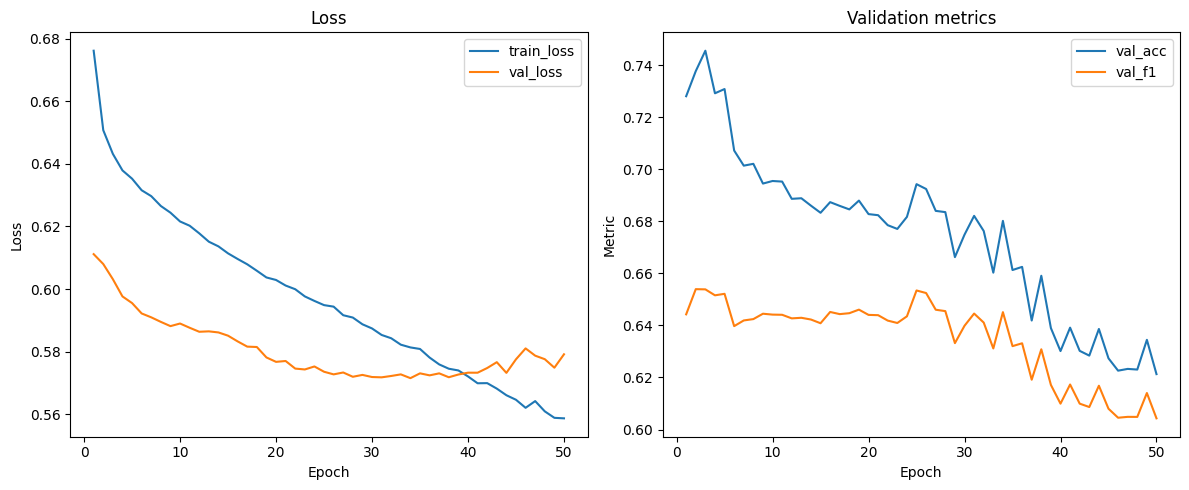

Final val_loss: 0.579188896758522, val_acc: 0.6213001071207082, val_f1: 0.6043135430792028


In [24]:
# train the model and plot loss & accuracy
print("Training NN...")
ff_model = FeedForwardModel(
    hidden_dims=[256, 128, 64],
    dropout=0.5,
    learning_rate=0.0001
)

history = ff_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=50,
    batch_size=256
)

# lot training/validation loss and validation accuracy
import matplotlib.pyplot as plt

epochs = range(1, len(history.get('train_loss', [])) + 1)

plt.figure(figsize=(12, 5))

# loss subplot
plt.subplot(1, 2, 1)
if 'train_loss' in history:
    plt.plot(epochs, history['train_loss'], label='train_loss')
if 'val_loss' in history:
    plt.plot(epochs, history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# accuracy / metrics subplot
plt.subplot(1, 2, 2)
plotted = False
if 'val_acc' in history:
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plotted = True
if 'val_f1' in history:
    plt.plot(epochs, history['val_f1'], label='val_f1')
    plotted = True
if not plotted:
    plt.text(0.5, 0.5, 'No validation metrics in history', ha='center')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation metrics')
plt.legend()

plt.tight_layout()
plt.show()

final_val_loss = history.get('val_loss', [None])[-1]
final_val_acc = history.get('val_acc', [None])[-1]
final_val_f1  = history.get('val_f1', [None])[-1]
print(f"Final val_loss: {final_val_loss}, val_acc: {final_val_acc}, val_f1: {final_val_f1}")

In [ ]:
# save the trained model
model_path = "ff_model.pth"
torch.save(ff_model.model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ff_model.pth
